In [2]:
import os
import re
import pymorphy2
from nltk.tokenize import sent_tokenize, wordpunct_tokenize
import zipfile
from tqdm import tqdm
import json
from networkx.readwrite import json_graph
import math
import random
import torch
import pandas as pd
import math
from abc import ABC, abstractmethod
from copy import copy
import statistics

In [26]:
morph = pymorphy2.MorphAnalyzer()

In [118]:
def sentence2feature_set(sentence):
    features_set = set()
    tokens = wordpunct_tokenize(sentence)
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            parsing_result = morph.parse(token)[0]
            lemma = parsing_result.normal_form
            tag = parsing_result.tag
            if 'NOUN' in tag:
                case = tag.case if hasattr(tag, 'case') else 'None'
                lemma_representation = case + '_' + lemma
                if any([proper_name_tag in tag for proper_name_tag in ['Name', 'Surn', 'Patr', 'Geox']]):
                    lemma_representation = 'proper_' + lemma_representation
                features_set.add(lemma_representation)
            elif 'VERB' in tag:
                features_set.add('verblemma_' + lemma)
                features_set.add('verbtoken_' + token.lower())
    return features_set
    
    
def text2features(fb2_path, encoding='utf-8'):
    with open(fb2_path, encoding=encoding) as f:
        text = f.read()

    #split paragraphs and separate inner xml tags from words
    paragraphs = [re.sub('<[^>]+>', ' ', paragraph) for paragraph in re.split('</?p>', text)]
    paragraphs = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]
    new_paragraphs = []
    previous_paragraph = ''
    #we do not want to split dialogs parts into several paragraphs
    for paragraph in paragraphs:
        if paragraph.startswith('–'):
            previous_paragraph = '. '.join([previous_paragraph, paragraph])
        else:
            if previous_paragraph:
                new_paragraphs.append(previous_paragraph)
            previous_paragraph = paragraph
    new_paragraphs.append(previous_paragraph)
    
    sentence_sequences = []
    paragraphs_representations = []
    
    for paragraph in new_paragraphs:
        sentences = sent_tokenize(paragraph)
        sentence_features = [sentence2feature_set(sentence) for sentence in sentences]
        
        #we transform sets into list in order to store data as json
        if len(sentences) > 1:
            sentence_sequences.append([list(sentence_data) for sentence_data in sentence_features])
            paragraph_set = sentence_features[0].union(*sentence_features[1:])
            paragraphs_representations.append(list(paragraph_set))
        #one sentence paragraph case
        elif sentences:
            paragraphs_representations.append(list(sentence_features[0]))
    return sentence_sequences, paragraphs_representations

In [175]:
def unzip_all_files_in_dir(dir_name, extension='.zip'):
    prev_workdir = os.getcwd()
    os.chdir(dir_name) # change directory from working dir to dir with files
    for item in tqdm(os.listdir(dir_name)): # loop through items in dir
        if item.endswith(extension): # check for ".zip" extension
            try:
                file_name = os.path.abspath(item) # get full path of files
                zip_ref = zipfile.ZipFile(file_name) # create zipfile object
                zip_ref.extractall(dir_name) # extract file to dir
                zip_ref.close() # close file
                os.remove(file_name) # delete zipped file
            except PermissionError:
                pass
    os.chdir(prev_workdir)

In [225]:
fb2_corpus_root_parh = 'D:\\Диплом_текстовые_квесты\\Publik House'

In [176]:
for directory in os.listdir(fb2_corpus_root_parh):
    directory_path = os.path.join(fb2_corpus_root_parh, directory)
    if os.path.isdir(directory_path):
        unzip_all_files_in_dir(directory_path)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.77it/s]


In [181]:
os.listdir('D:\Диплом_текстовые_квесты\Publik House\10')

OSError: [WinError 123] Синтаксическая ошибка в имени файла, имени папки или метке тома: 'D:\\Диплом_текстовые_квесты\\Publik House\x08'

In [196]:
test_file = os.path.join('D:\\Диплом_текстовые_квесты\\Publik House\\10', 'Emis_Vezunchik_Dzhim_RuLit_Net.fb2')

In [183]:
import charset_normalizer

In [190]:
with open(test_file, 'rb') as f:
    file_content = f.read()
    encoding = charset_normalizer.detect(file_content)['encoding']

C:\Users\user\anaconda3\lib\site-packages\charset_normalizer\normalizer.py:406: UserWarning: Trying to detect encoding on a sequence that seems to declare a encoding (cp1251).
  warn(


In [191]:
encoding

'cp1251'

In [192]:
with open(test_file, encoding=encoding) as f:
    test_text = f.read()

In [6]:
features_directory = 'D:\\Диплом_текстовые_квесты\\fiction_statistics'

In [236]:
directory_path

'D:\\Диплом_текстовые_квесты\\Publik House\\ '

In [243]:
def guess_encoding(file_path):
    with open(file_path, 'rb') as f:
        file_content = f.read()
        encoding = charset_normalizer.detect(file_content)['encoding']
    return encoding

In [265]:
#fails = []
already_extracted_dirs = ['0', '1', '10', '11']
for data_directory_name in [directory for directory in os.listdir(fb2_corpus_root_parh) if directory not in already_extracted_dirs]:
    directory_path = os.path.join(fb2_corpus_root_parh, data_directory_name)
    if os.path.isdir(directory_path):
        fb2_files = [file for file in os.listdir(directory_path) if file.endswith('.fb2')]
        if fb2_files:
            sents_data = []
            paragraphs_data = []
            for file_name in tqdm(fb2_files):
                try:
                    file_path = os.path.join(directory_path, file_name)
                    encoding = guess_encoding(file_path)
                    try:
                        sentence_sequences, paragraphs_representations = text2features(file_path, encoding)
                        sents_data += sentence_sequences
                        paragraphs_data += paragraphs_representations
                    except UnicodeDecodeError:
                        fails.append([file_path, encoding])
                except PermissionError:
                    fails.append([file_path, None])
            with open(os.path.join(features_directory, data_directory_name + '.json'), 'w', encoding='utf-8') as f:
                json.dump({'sents_data': sents_data, 'paragraphs_data': paragraphs_data}, f)
        



  0%|                                                                                           | 0/99 [00:00<?, ?it/s]

  1%|▊                                                                                  | 1/99 [00:33<55:27, 33.96s/it]

  2%|█▋                                                                                 | 2/99 [01:09<55:26, 34.30s/it]

  3%|██▌                                                                                | 3/99 [01:38<52:39, 32.91s/it]

  4%|███▎                                                                               | 4/99 [02:07<50:03, 31.61s/it]

  5%|████▏                                                                              | 5/99 [02:16<38:49, 24.78s/it]

  6%|█████                                                                              | 6/99 [02:32<34:27, 22.24s/it]

  7%|█████▋                                                                           | 7/99 [03:53<1:01:20, 40.00s/it]

  8%|██████▋                  

Размеры корпуса

In [4]:
num_books = 0
FICTION_BOOKS_DIRECTORY = 'D:\Диплом_текстовые_квесты\Publik House'
for directory in os.listdir(FICTION_BOOKS_DIRECTORY):
    books = [file for file in os.listdir(os.path.join(FICTION_BOOKS_DIRECTORY, directory)) if file.endswith('fb2')]
    num_books += len(books)
num_books

2445

In [16]:
import json

In [18]:
num_paragraphs = 0
num_nouns = 0
num_verbs = 0

for file in os.listdir(features_directory):
    if file.endswith('.json'):
        with open(os.path.join(features_directory, file), encoding='utf-8') as f:
            data = json.load(f)
        paragraphs_data = data['paragraphs_data']
        num_paragraphs += len(paragraphs_data)
        for paragraph_data in paragraphs_data:
            for feature in paragraph_data:
                if 'verb' in feature:
                    if 'token' in feature:
                        num_verbs += 1
                else:
                    num_nouns += 1

In [19]:
num_paragraphs, num_nouns, num_verbs

(4231682, 39040637, 19409315)

In [12]:
with open('D:\\Диплом_текстовые_квесты\\fiction_statistics\\0.json', encoding='utf-8'):
    pass

In [ ]:
D:\Диплом_текстовые_квесты\fiction_statistics

Используем для модели

In [124]:
def prepare_single_feature(feature):
    if 'verb' in feature:
        return feature
    else:
        if 'proper' in feature:
            return 'proper'
        else:
            return feature.split('_')[-1]

def prepare_features_pair(feature1, feature2):
    if 'proper_' in feature1 and 'proper_' in feature2:
        if feature1.split('_')[-1] == feature1.split('_')[-1]:
            return 'proper','other_proper'
        else:
            return 'proper', 'similar_proper'
    else:
        return prepare_single_feature(feature1), prepare_single_feature(feature2)

In [8]:
from sklearn.model_selection import train_test_split


online_quest_paths_dir = 'D:\\Диплом_текстовые_квесты\\random_paths'
graphs_with_options_dir = 'D:\\Диплом_текстовые_квесты\\Data\\questbook_online_joined_texts'

train, test = train_test_split(os.listdir(online_quest_paths_dir), random_state=42, test_size=0.4)

#online_test = [path for path in test if 'questbook_online_joined_texts' in path]
test_pairwise, test_ordering = train_test_split(test, random_state=42, test_size=0.5)

test1 = [os.path.join(graphs_with_options_dir, path) for path in test_pairwise]
test2 = [os.path.join(graphs_with_options_dir, path) for path in test_ordering]
all_test = test1 + test2

#vocab = {'OOV':'OOV', 'empty_set':1, 'proper':2, 'other_proper':3, 'similar_proper':4}


In [7]:
num_fragments = 0
num_empty_sets = 0

all_feature_sets = []

for file in tqdm(test):
    with open(os.path.join(online_quest_paths_dir, file), encoding='utf-8') as f:
        test_paths = json.load(f)
        
    with open(os.path.join(graphs_with_options_dir, file), encoding='utf-8') as f:
        G = json_graph.node_link_graph(json.load(f))
        
    nodes = G.nodes()
    real_nodes = [node_id for node_id in nodes if 'fragment_text' in nodes[node_id] and isinstance(nodes[node_id]['fragment_text'] ,str) and nodes[node_id]['fragment_text'].strip()]
    for test_path in test_paths:
        texts = [nodes[node_id]['fragment_text'] for node_id in test_path if node_id in real_nodes]
        if len(texts) >=2:
            feature_sets = [sentence2feature_set(text) for text in texts]
            all_feature_sets += feature_sets
            for feature_set in feature_sets:
                num_fragments += 1
                if not feature_set:
                    num_empty_sets += 1
                #for feature in feature_set:
                    #feature_tag = prepare_single_feature(feature)
                    #if feature_tag not in vocab:
                        #vocab[feature_tag] = len(vocab)
                        
#with open('D:\\Диплом_текстовые_квесты\\fiction_statistics\\probability_models\\test_vocab.json', 'w', encoding='utf-8') as f:
    #json.dump(vocab, f)

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [32:10<00:00, 35.75s/it]


In [8]:
num_fragments

51034

In [9]:
num_empty_sets

22

In [127]:
class OrderingProbabilisticModel:
    def __init__(self, vocab, oov_token = 'OOV'):
        self.vocab = vocab
        self.oov_token = oov_token
        self.data = {}
        self.string_data = False
        
    def add_pair(self, feature_from, feature_to):
        feature_from_id = self.get_feature_id(feature_from)
        feature_to_id = self.get_feature_id(feature_to)

        
        if feature_from_id not in self.data:
            self.data[feature_from_id] = {}
            
        if feature_to_id not in self.data[feature_from_id]:
            self.data[feature_from_id][feature_to_id] = 1
        else:
            self.data[feature_from_id][feature_to_id] += 1
        
    def get_feature_id(self, feature):
        if feature in self.vocab:
            return self.vocab[feature]
        else:
            return self.oov_token
        
        
    def calc_transition_probability(self, feature_from, feature_to):
        feature_from_id = self.get_feature_id(feature_from)
        feature_to_id = self.get_feature_id(feature_to)
        
        if feature_from_id not in self.data:
            return 0
        else:
            next_features_data = self.data[feature_from_id]
            if feature_to_id not in next_features_data:
                return 0
            else:
                return next_features_data[feature_to_id]/len(next_features_data)
        
           
    def dump(self, file_path):
        with open(file_path, 'w', encoding='utf-8') as f:
            json.dump(self.data, f)
            
    def load(self, file_path):
        with open(file_path, encoding='utf-8') as f:
            self.data = json.load(f)

In [55]:
def calc_transition_probability(model, feature_from, feature_to):
        feature_from_id = model.get_feature_id(feature_from)
        feature_to_id = model.get_feature_id(feature_to)
        
        if feature_from_id not in model.data:
            print(type(feature_from_id))
            return 0
        else:
            next_features_data = model.data[feature_from_id]
            print(len(next_features_data))
            if feature_to_id not in next_features_data:
                return 0
            else:
                return next_features_data[feature_to_id]/len(next_features_data)

In [128]:
models_subdirectory = 'probability_models'
paragraph_model_path = os.path.join(features_directory, models_subdirectory, 'paragraph_data.json')
vocab_path = os.path.join(features_directory, models_subdirectory, 'test_vocab.json')
with open(vocab_path, encoding='utf-8') as f:
    vocab = json.load(f)

paragraph_probabilistic_model = OrderingProbabilisticModel(vocab)
paragraph_probabilistic_model.string_data = True

In [129]:
paragraph_probabilistic_model.load(paragraph_model_path)

In [16]:
def add_sequence(sequence):
    if len(sequence) >= 2:
        for features_from, features_to in zip(sequence[:-1], sequence[1:]):
            transitions_set = set()
            for feature_from in features_from:
                for feature_to in features_to:
                    transitions_set.add(prepare_features_pair(feature_from, feature_to))
            for feature_from, feature_to in transitions_set:
                paragraph_probabilistic_model.add_pair(feature_from, feature_to)

In [17]:
already_extracted = ['0.json', '1.json', '10.json', '11.json', '12.json', '13.json', '14.json', '15.json', '16.json', '17.json', '18.json', '19.json', '2.json', '20.json', '21.json', '22.json', '23.json']
for file_name in tqdm([item for item in os.listdir(features_directory) if item.endswith('.json') and item not in already_extracted]):
    print(file_name)
    file_path = os.path.join(features_directory, file_name)
    data = json.load(open(file_path))
    
    add_sequence(data['paragraphs_data'])
    paragraph_probabilistic_model.dump(paragraph_model_path)
    

  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

24.json


  6%|████▊                                                                             | 1/17 [03:37<57:58, 217.39s/it]

25.json


 12%|█████████▋                                                                        | 2/17 [07:48<56:53, 227.58s/it]

26.json


 18%|██████████████▍                                                                   | 3/17 [11:40<53:21, 228.69s/it]

27.json


 24%|███████████████████▎                                                              | 4/17 [16:03<51:46, 238.99s/it]

28.json


 29%|████████████████████████                                                          | 5/17 [20:14<48:33, 242.76s/it]

29.json


 35%|████████████████████████████▉                                                     | 6/17 [24:02<43:41, 238.30s/it]

3.json


 41%|████████████████████████████████▉                                               | 7/17 [34:56<1:00:31, 363.16s/it]

30.json


 47%|██████████████████████████████████████▌                                           | 8/17 [40:58<54:24, 362.70s/it]

31.json


 53%|███████████████████████████████████████████▍                                      | 9/17 [45:29<44:40, 335.07s/it]

32.json


 59%|███████████████████████████████████████████████▋                                 | 10/17 [51:46<40:34, 347.73s/it]

33.json


 65%|████████████████████████████████████████████████████▍                            | 11/17 [56:10<32:16, 322.75s/it]

4.json


 71%|███████████████████████████████████████████████████████▊                       | 12/17 [1:06:21<34:05, 409.06s/it]

5.json


 76%|████████████████████████████████████████████████████████████▍                  | 13/17 [1:16:50<31:40, 475.09s/it]

6.json


 82%|█████████████████████████████████████████████████████████████████              | 14/17 [1:26:18<25:08, 502.96s/it]

7.json


 88%|█████████████████████████████████████████████████████████████████████▋         | 15/17 [1:37:23<18:23, 551.52s/it]

8.json


 94%|██████████████████████████████████████████████████████████████████████████▎    | 16/17 [1:51:22<10:37, 637.91s/it]

9.json


100%|███████████████████████████████████████████████████████████████████████████████| 17/17 [2:03:20<00:00, 435.30s/it]


In [3]:
class QuestTextDataset(torch.utils.data.Dataset):
    def __init__(self, quest_paths, target_positive_proportion = 0.5, stop_looking_for_negative_coef = 3, random_seed=42):
        super().__init__()
        random.seed = random_seed
        self.quest_paths = quest_paths
        self.data = []
        self.stop_looking_for_negative_coef = stop_looking_for_negative_coef
        self.adding_negative_coef = (1-target_positive_proportion)/target_positive_proportion
        for graph_path in tqdm(self.quest_paths):
            try:
                G = self.read_graph(graph_path)
                self.data += self.process_quest_graph(G)
            except Exception as e:
                print(graph_path)
                print(e)


            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        pair, category = self.data[i]
        fragment1, fragment2 = pair
        return fragment1, fragment2, category
        
            
    def read_graph(self, graph_path):
        return json_graph.node_link_graph(json.load(open(graph_path, encoding='utf-8')))
        
    def process_quest_graph(self, G):
        edges = G.edges()
        nodes = G.nodes()
        nodes_with_text = [node for node in nodes if 'fragment_text' in nodes[node] and isinstance(nodes[node]['fragment_text'], str) and nodes[node]['fragment_text'].strip()]
        positive_samples = [[(self.get_node_data(node_from, nodes), self.get_node_data(node_to, nodes)), 1] for node_to, node_from in G.edges() if node_to in nodes_with_text and node_from in nodes_with_text] 
    
        target_num_negatives = round(len(positive_samples) * self.adding_negative_coef)
        max_tries = target_num_negatives * self.stop_looking_for_negative_coef
        negative_pairs = []
        for i in range(max_tries):
            negative_candidates = tuple(random.choices(nodes_with_text, k=2))
            if not G.has_edge(*negative_candidates) and negative_candidates not in negative_pairs:
                negative_pairs.append(negative_candidates)
            if len(negative_pairs) >= target_num_negatives:
                break
        negative_samples = [[(self.get_node_data(node_from, nodes), self.get_node_data(node_to, nodes)), 0] for node_from, node_to in negative_pairs]
        all_samples = positive_samples + negative_samples
        random.shuffle(positive_samples+negative_samples)
        return all_samples
    
    def get_node_data(self, node_id, nodes):
        return nodes[node_id]['fragment_text']


In [9]:
pairwise_dataset = QuestTextDataset(all_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 53.76it/s]


In [116]:
epsilons=[0.0000001, 0.000001, 0.00001, 0.0001, 0.005, 0.01]

In [56]:
def calc_log_geom_proba(probabilities, epsilon):
    if not probabilities:
        return 0
    else:
        product = 1
        for probability in probabilities:
            if probability:
                product *= math.log10(probability)
            else:
                product *= math.log10(epsilon)
            return product/len(probabilities)

def calc_log_transition_probability_test_coefs(features_from, features_to, epsilons=epsilons):
    probabilities = []
    for feature_from in features_from:
        for feature_to in features_to:
            prepared_feature1, prepared_feature2 = prepare_features_pair(feature_from, feature_to)
            probability = paragraph_probabilistic_model.calc_transition_probability(prepared_feature1, prepared_feature2)
            probabilities.append(probability)
    #if there are no zero probabilities, we will get the same results for all epsilons
    if all(probabilities):
        result = calc_log_geom_proba(probabilities, 1)
        return([result for epsilon in epsilons])
    else:
        return [calc_log_geom_proba(probabilities, epsilon) for epsilon in epsilons]

In [61]:
results = []

for fragment_from, fragment_to, correct in tqdm(pairwise_dataset):
    features_from = sentence2feature_set(fragment_from)
    features_to = sentence2feature_set(fragment_to)
    if features_from and features_to:
        predictions = calc_log_transition_probability_test_coefs(features_from, features_to)
        results.append({'predictions':predictions, 'correct':correct})
        
with open(os.path.join(features_directory, models_subdirectory, 'statistic_predictios.json'), 'w', encoding='utf-8') as f:
    json.dump({'results':results, 'epsilons':epsilons}, f)


100%|██████████████████████████████████████████████████████████████████████████████| 7338/7338 [09:05<00:00, 13.45it/s]


In [62]:
from sklearn import metrics

In [63]:
correct = [result['correct'] for result in results]
for i, epsilon in enumerate(epsilons):
    predicted = [10.0**result['predictions'][i] for result in results]
    fpr, tpr, thresholds = metrics.roc_curve(correct, predicted, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    print('epsilon='+str(epsilon), 'auc='+str(roc_auc))

epsilon=1e-07 auc=0.4944208702881239
epsilon=1e-06 auc=0.4944208702881239
epsilon=0.1 auc=0.4944208702881239
epsilon=0.0001 auc=0.4944208702881239
epsilon=0.005 auc=0.4944208702881239
epsilon=0.01 auc=0.4944208702881239


In [122]:
from statistics import mean
def calc_mean_probability(features_from, features_to, epsilon):
    probabilities = []
    for feature_from in features_from:
        for feature_to in features_to:
            prepared_feature1, prepared_feature2 = prepare_features_pair(feature_from, feature_to)
            probability = paragraph_probabilistic_model.calc_transition_probability(prepared_feature1, prepared_feature2)
            if probability:
                probabilities.append(probability)
            else:
                probabilities.append(epsilon)
    return mean(probabilities)
    

In [72]:
predicted = []
correct = []

for fragment_from, fragment_to, correct_label in tqdm(pairwise_dataset):
    features_from = sentence2feature_set(fragment_from)
    features_to = sentence2feature_set(fragment_to)
    if features_from and features_to:
        prediction = calc_mean_probability(features_from, features_to)
        predicted.append(prediction)
        correct.append(correct_label)
        
#with open(os.path.join(features_directory, models_subdirectory, 'statistic_predictios.json'), 'w', encoding='utf-8') as f:
#    json.dump({'results':results, 'epsilons':epsilons}, f)


100%|██████████████████████████████████████████████████████████████████████████████| 7338/7338 [09:44<00:00, 12.54it/s]


In [73]:
fpr, tpr, thresholds = metrics.roc_curve(correct, predicted, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.5138339747957779

In [ ]:
predicted = [[] for i in epsilons]
correct = []

for fragment_from, fragment_to, correct_label in tqdm(pairwise_dataset):
    features_from = sentence2feature_set(fragment_from)
    features_to = sentence2feature_set(fragment_to)
    if features_from and features_to:
        for i, epsilon in enumerate(epsilons):
            prediction = calc_mean_probability(features_from, features_to, epsilon)
            predicted[i].append(prediction)
        correct.append(correct_label)

In [134]:
for epsilon, prediction in zip(epsilons, predicted):
    fpr, tpr, thresholds = metrics.roc_curve(correct, prediction, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    print('epsilon=' +str(epsilon), 'roc_auc='+str(roc_auc))

epsilon=1e-07 roc_auc=0.5096912636547991
epsilon=1e-06 roc_auc=0.5096912636547991
epsilon=1e-05 roc_auc=0.5096912636547991
epsilon=0.0001 roc_auc=0.5096912636547991
epsilon=0.005 roc_auc=0.5096912636547991
epsilon=0.01 roc_auc=0.5096912636547991


In [66]:
num_pairs = 0
num_unknown_pairs = 0
meaningful_pairs = 0

tech_features = ['OOV', 'empty_set', 'proper', 'other_proper', 'similar_proper']
for fragment_from, fragment_to, correct_label in tqdm(pairwise_dataset):
    features_from = sentence2feature_set(fragment_from)
    features_to = sentence2feature_set(fragment_to)
    if features_from and features_to:
        for feature_from in features_from:
            for feature_to in features_to:
                prepared_feature1, prepared_feature2 = prepare_features_pair(feature_from, feature_to)
                probability = paragraph_probabilistic_model.calc_transition_probability(prepared_feature1, prepared_feature2)
                num_pairs += 1
                if not probability:
                    num_unknown_pairs += 1
                else:
                    if prepared_feature1 not in tech_features and prepared_feature2 not in tech_features:
                        meaningful_pairs += 1
                        


100%|██████████████████████████████████████████████████████████████████████████████| 7338/7338 [09:02<00:00, 13.52it/s]


In [33]:
transition_types = ['SO-SO', 'SO-X', 'X-SO', 'X-X', 'SO-_', '_-SO', 'X-_', '_-X']

In [34]:
transition_type2id = {transition_type:i for i, transition_type in enumerate(transition_types)}

In [4]:
from abc import ABC, abstractmethod

In [5]:
class PairPreprocessor(ABC):
    def __init__(self):
        self.subj_obj_tag = 'SO'
        self.other_tag = 'X'
        
        
    def case2tag(self, feature):
        return 'SO' if feature in ['nomn', 'accs', 'gent'] else 'X'
    
    def fragment_pair2transitions(self, fragment1, fragment2):
        fragment1_nouns = self.text2nouns(fragment1)
        fragment2_nouns = self.text2nouns(fragment2)
        
        return self.nouns2transitions(fragment1_nouns, fragment2_nouns)
    
    
    def nouns2transitions(self, fragment1_nouns, fragment2_nouns):
        transitions = []
        for noun, label1 in fragment1_nouns.items():
            label2 = fragment2_nouns[noun] if noun in fragment2_nouns else '_'
            transition = '-'.join([label1, label2])
            transitions.append(transition)
        for noun, label2 in fragment2_nouns.items():
            if noun not in fragment1_nouns:
                transition = '-'.join(['_', label2])
                transitions.append(transition)
        return transitions
    
    @abstractmethod
    def text2nouns(self, text):
        pass
    
class TextPairPreprocessor(PairPreprocessor):
    
    def text2nouns(self, text):
        nouns = {}
        for token in wordpunct_tokenize(text):
            p = morph.parse(token)[0]
            if 'NOUN' in p.tag:
                lemma = p.normal_form
                if lemma not in nouns or nouns[lemma] == self.other_tag:
                    nouns[lemma] = self.parse2tag(p)
        return nouns

    def parse2tag(self, parse):
        if hasattr(parse.tag, 'case'):
            return self.case2tag(parse.tag.case)



In [12]:
class FeatureSetPairPreprocessor(PairPreprocessor):
    def text2nouns(self, feature_set):
        nouns = {}
        for feature in feature_set:
            if 'verb' not in feature:
                parts = feature.split('_')
                try:
                    lemma = parts[-1]
                    case = parts[-2]
                    if lemma not in nouns or nouns[lemma] == self.other_tag:
                        nouns[lemma] = self.case2tag(parts[-2])
                except:
                    print(feature)
        return nouns
            

In [13]:
def fragment_sequence_data2samples(fragment_sequence):
    if len(fragment_sequence) > 2:
        samples = [(fragment_from, fragment_to, 1) for fragment_from, fragment_to in zip(fragment_sequence[:-1], fragment_sequence[1:])]
        positions = [i for i in range(len(samples))]
        for i in range(len(samples)):
            random_position1, random_position2 = random.choices(positions, k=2)
            if random_position2 - random_position1 != 1:
                samples.append((fragment_sequence[random_position1], fragment_sequence[random_position2], 0))
        random.shuffle(samples)
        return samples    

In [6]:
class TransitionsNetwork(torch.nn.Module):
    def __init__(self, num_transition_types, embedding_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(num_embeddings=num_transition_types, embedding_dim=embedding_dim)
        self.linear = torch.nn.Linear(embedding_dim, 1)
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = torch.mean(x, 0)
        x = self.linear(x)
        return torch.sigmoid(x)

In [13]:
train_feature_preprocessor = FeatureSetPairPreprocessor()

In [10]:
model = TransitionsNetwork(num_transition_types=len(transition_types), embedding_dim=10)

In [31]:
model.train()
optimizer =  torch.optim.Adam([{'params': model.parameters()}], 
                               lr = 1e-3)
criterion = torch.nn.BCELoss()

In [33]:
already_extracted = []
sample_id = 0
for file_name in tqdm([item for item in os.listdir(features_directory) if item.endswith('.json') and item not in already_extracted]):
    print(file_name)
    file_path = os.path.join(features_directory, file_name)
    data = json.load(open(file_path))
    
    sequence = data['paragraphs_data']
    samples = fragment_sequence_data2samples(sequence)
    for fragment_from, fragment_to, label in samples:
        transitions = train_feature_preprocessor.fragment_pair2transitions(fragment_from, fragment_to)
        if transitions:
            x = torch.tensor([transition_type2id[transition] for transition in transitions])
            prediction = model(x)
            loss = criterion(prediction, torch.tensor([label]).float())
            loss.backward()
            sample_id += 1
            if sample_id % 20 == 0:
                optimizer.step()
                optimizer.zero_grad()
            if sample_id % 1000 == 0:
                torch.save(model, 'transitions_model.pth')
        
        

  0%|                                                                                           | 0/34 [00:00<?, ?it/s]

0.json


  3%|██▍                                                                                | 1/34 [01:26<47:28, 86.31s/it]

1.json


  6%|████▊                                                                             | 2/34 [03:57<56:27, 105.86s/it]

10.json


  9%|███████                                                                         | 3/34 [06:54<1:05:41, 127.14s/it]

11.json


 12%|█████████▍                                                                      | 4/34 [09:50<1:10:54, 141.81s/it]

12.json


 15%|███████████▊                                                                    | 5/34 [12:52<1:14:23, 153.93s/it]

13.json


 18%|██████████████                                                                  | 6/34 [17:26<1:28:33, 189.77s/it]

14.json


 21%|████████████████▍                                                               | 7/34 [20:47<1:26:59, 193.33s/it]

15.json


 24%|██████████████████▊                                                             | 8/34 [23:38<1:20:49, 186.51s/it]

16.json


 26%|█████████████████████▏                                                          | 9/34 [26:43<1:17:29, 185.99s/it]

17.json


 29%|███████████████████████▏                                                       | 10/34 [29:46<1:14:03, 185.15s/it]

18.json


 32%|█████████████████████████▌                                                     | 11/34 [33:14<1:13:38, 192.10s/it]

19.json


 35%|███████████████████████████▉                                                   | 12/34 [35:45<1:05:53, 179.70s/it]

2.json


 38%|██████████████████████████████▉                                                  | 13/34 [38:04<58:37, 167.51s/it]

20.json


 41%|█████████████████████████████████▎                                               | 14/34 [39:21<46:45, 140.26s/it]

21.json


 44%|███████████████████████████████████▋                                             | 15/34 [40:35<38:07, 120.40s/it]

22.json


 47%|██████████████████████████████████████▌                                           | 16/34 [40:57<27:16, 90.89s/it]

23.json


 50%|████████████████████████████████████████▌                                        | 17/34 [43:49<32:38, 115.20s/it]

24.json


 53%|██████████████████████████████████████████▉                                      | 18/34 [45:26<29:16, 109.77s/it]

25.json


 56%|█████████████████████████████████████████████▎                                   | 19/34 [46:53<25:43, 102.91s/it]

26.json


 59%|████████████████████████████████████████████████▏                                 | 20/34 [48:05<21:52, 93.74s/it]

27.json


 62%|██████████████████████████████████████████████████▋                               | 21/34 [49:29<19:40, 90.84s/it]

28.json


 65%|█████████████████████████████████████████████████████                             | 22/34 [50:48<17:27, 87.33s/it]

29.json


 68%|███████████████████████████████████████████████████████▍                          | 23/34 [51:53<14:44, 80.42s/it]

3.json


 71%|█████████████████████████████████████████████████████████▉                        | 24/34 [54:12<16:22, 98.21s/it]

30.json


 74%|████████████████████████████████████████████████████████████▎                     | 25/34 [55:03<12:36, 84.08s/it]

31.json


 76%|██████████████████████████████████████████████████████████████▋                   | 26/34 [55:27<08:47, 65.90s/it]

32.json


 79%|█████████████████████████████████████████████████████████████████                 | 27/34 [56:23<07:19, 62.83s/it]

33.json


 82%|███████████████████████████████████████████████████████████████████▌              | 28/34 [57:08<05:45, 57.54s/it]

4.json


 85%|████████████████████████████████████████████████████████████████████▏           | 29/34 [1:00:01<07:41, 92.32s/it]

5.json


 88%|█████████████████████████████████████████████████████████████████████▋         | 30/34 [1:03:43<08:44, 131.01s/it]

6.json


 91%|████████████████████████████████████████████████████████████████████████       | 31/34 [1:06:46<07:20, 146.79s/it]

7.json


 94%|██████████████████████████████████████████████████████████████████████████▎    | 32/34 [1:10:21<05:34, 167.11s/it]

8.json


 97%|████████████████████████████████████████████████████████████████████████████▋  | 33/34 [1:14:30<03:11, 191.79s/it]

9.json


100%|███████████████████████████████████████████████████████████████████████████████| 34/34 [1:17:40<00:00, 137.07s/it]


In [4]:
model = torch.load('transitions_model.pth')

In [31]:
sorted([[transition_type, model(torch.tensor([i]))] for i, transition_type in enumerate(transition_types)], key=lambda x: x[1])

[['X-_', tensor([0.3646], grad_fn=<SigmoidBackward>)],
 ['_-X', tensor([0.3693], grad_fn=<SigmoidBackward>)],
 ['_-SO', tensor([0.4017], grad_fn=<SigmoidBackward>)],
 ['SO-_', tensor([0.4262], grad_fn=<SigmoidBackward>)],
 ['SO-SO', tensor([1.], grad_fn=<SigmoidBackward>)],
 ['SO-X', tensor([1.], grad_fn=<SigmoidBackward>)],
 ['X-SO', tensor([1.], grad_fn=<SigmoidBackward>)],
 ['X-X', tensor([1.], grad_fn=<SigmoidBackward>)]]

In [24]:
text_pair_preprocessor = TextPairPreprocessor()

In [70]:
fragment1, fragment2, label = pairwise_dataset[2]

In [27]:
predicted = []
correct = []

for i in range(len(pairwise_dataset)):
    fragments, label = pairwise_dataset.data[i]
    fragment1 = fragments[0]
    fragment2 = fragments[1]
    transitions = text_pair_preprocessor.fragment_pair2transitions(fragment1, fragment2)
    if transitions:
        x = torch.tensor([transition_type2id[transition] for transition in transitions])
        prediction = model(x)
        correct.append(label)
        predicted.append(float(prediction))

In [29]:
from sklearn import metrics

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(correct, predicted, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.6819318803484818

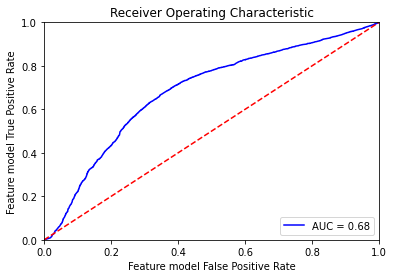

In [31]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Feature model True Positive Rate')
plt.xlabel('Feature model False Positive Rate')
plt.show()

In [6]:
fragments_cash = {}

In [5]:
class Fragment:
    def __init__(self, fragment_id, text):
        self.fragment_id = fragment_id
        self.text = text
        if text in fragments_cash:
            self.nouns = fragments_cash[text]
        else:
            nouns = text_pair_preprocessor.text2nouns(text)
            self.nouns = nouns
            fragments_cash[text] = nouns           

In [14]:
from copy import copy

In [31]:
pair_cash = {}
def score_pair(fragment1, fragment2):
    if (fragment1.text, fragment2.text) in pair_cash:
        return pair_cash[(fragment1.text, fragment2.text)]
    else:
        if not fragment1.nouns and not fragment2.nouns:
            prediction = 0
        else:
            transitions = text_pair_preprocessor.nouns2transitions(fragment1.nouns, fragment2.nouns)
            x = torch.tensor([transition_type2id[transition] for transition in transitions])
            prediction = model(x)
        pair_cash[(fragment1.text, fragment2.text)] = prediction
        return prediction

In [38]:
def entity_grid_beam_search(test_sample, quest_graph, model, num_best_candidates=3, text_key='fragment_text'):
    nodes = quest_graph.nodes()
    texts = [nodes[node_id][text_key] for node_id in test_sample]
    fragments = [Fragment(node_id, text) for node_id, text in zip(test_sample, texts)]
    
    order_candidates = [{'beginning':[fragments[0]], 'next_candidates':copy(fragments[1:]), 'probability':1}]
    random.shuffle(order_candidates[0]['next_candidates'])
    
    for i in range(len(fragments)-1):
        current_iteration_next_candidates = []
        
        for order_candidate in order_candidates:
            last_fragment = order_candidate ['beginning'][-1]
            
            
            scored_next = [{'next_fragment':next_fragment, 'score':score_pair(last_fragment, next_fragment)} for next_fragment in order_candidate['next_candidates']]
            scored_next.sort(key=lambda x: x['score'], reverse=True)
            
            chosen_next_candidates = scored_next[:num_best_candidates] if len(scored_next) < num_best_candidates else scored_next
            for chosen_next_candidate in chosen_next_candidates:
                next_fragment = chosen_next_candidate['next_fragment']
                
                next_step_beginning = copy(order_candidate['beginning'])
                next_step_beginning.append(next_fragment)
                
                print(order_candodate)
                next_step_probability = order_candidate['probability']*chosen_next_candidate['score']
                
                next_step_next_candidates = []
                for next_step_next_candidate in order_candidate['next_candidates']:
                    if next_step_next_candidate.fragment_id != next_fragment.fragment_id:
                        next_step_next_candidates.append(next_step_next_candidate)
                
              
                current_iteration_next_candidates.append({'beginning':next_step_beginning, 'next_candidates':next_step_next_candidates, 'probability':next_step_probability})
        
        current_iteration_next_candidates.sort(key=lambda x: x['probability'], reverse=True)
        order_candidates = current_iteration_next_candidates[:num_best_candidates] if len(current_iteration_next_candidates) > num_best_candidates else  current_iteration_next_candidates
    return [fragment.fragment_id for fragment in order_candidates[0]['beginning']]

In [31]:
TEST_PATHS_DIRECTORY = 'D:\\Диплом_текстовые_квесты\\Data\\tokenized_ordering_test_joined'

In [39]:
result = []

for file in tqdm(os.listdir(TEST_PATHS_DIRECTORY)):
    with open(os.path.join(TEST_PATHS_DIRECTORY, file)) as f:
        _, path, graph_json, __ = json.load(f)
        
    graph = json_graph.node_link_graph(graph_json)
    prediction = entity_grid_beam_search(copy(path), graph, model)
    result.append({'correct':path, 'predicted':prediction})

with open('fiction_entity_grid_beam_search_result.json', 'w') as f:
    json.dump(result, f)



  0%|                                                                                         | 0/3429 [00:00<?, ?it/s]

  0%|                                                                                 | 3/3429 [00:00<06:33,  8.70it/s]

  0%|                                                                                 | 5/3429 [00:00<06:25,  8.88it/s]

  0%|▏                                                                                | 6/3429 [00:00<06:12,  9.19it/s]

  0%|▏                                                                                | 7/3429 [00:00<06:17,  9.06it/s]

  0%|▏                                                                                | 9/3429 [00:00<05:22, 10.61it/s]

  0%|▎                                                                               | 11/3429 [00:00<04:38, 12.28it/s]

  0%|▎                                                                               | 15/3429 [00:01<03:48, 14.95it/s]

  1%|▍                        

In [40]:
len(result)

3429

In [4]:
def longest_correct_subsequence(predicted, correct):
    correct_transitions = set([(item_from, item_to) for item_from, item_to in zip(correct[:-1], correct[1:])])
    predicted_transitions = [(item_from, item_to) for item_from, item_to in zip(predicted[:-1], predicted[1:])]
    predicted_transitions_are_correct = [transition in correct_transitions for transition in predicted_transitions]
    
    longest_correct_transitions_subsequence = 0
    current_correct_transitions_subsequence = 0
    #Add False as last item to include last real item checking into the loop
    for predicted_transition_is_correct in predicted_transitions_are_correct + [False]:
        if predicted_transition_is_correct:
            current_correct_transitions_subsequence += 1
        else:
            if current_correct_transitions_subsequence > longest_correct_transitions_subsequence:
                longest_correct_transitions_subsequence = current_correct_transitions_subsequence
            current_correct_transitions_subsequence = 0
    #return number of items in longest correct sequence (not number of transitions)
    return longest_correct_transitions_subsequence + 1 if longest_correct_transitions_subsequence else 0  

In [61]:
from scipy.stats import kendalltau

In [91]:
fiction_entitygrid_df = pd.DataFrame(columns = ["sequence length", "Kendall's  tau", "Longest correct subsequence"])
for sequence_data in result:
    predicted = sequence_data['predicted']
    correct = sequence_data['correct']
    tau = kendalltau(predicted[1:], correct[1:]).correlation
    lcs = longest_correct_subsequence(predicted, correct)
    fiction_entitygrid_df.loc[len(fiction_entitygrid_df)] = [len(correct), tau, lcs]
    

In [92]:
fiction_entitygrid_df["Kendall's  tau"].describe()

count    3429.000000
mean        0.003056
std         0.263009
min        -1.000000
25%        -0.142857
50%         0.000000
75%         0.142857
max         1.000000
Name: Kendall's  tau, dtype: float64

In [93]:
fiction_entitygrid_df_aggr = fiction_entitygrid_df[fiction_entitygrid_df["sequence length"]<=30].groupby("sequence length").describe()[[("Kendall's  tau", 'count'),  ("Kendall's  tau",  'mean'), ('Longest correct subsequence',  'mean')]]
fiction_entitygrid_df_aggr

Kendall's  tau           Longest correct subsequence
                         count      mean                        mean
sequence length                                                     
4.0                      100.0  0.206667                    2.020000
5.0                       97.0  0.089347                    1.608247
6.0                      150.0 -0.141333                    1.680000
7.0                      152.0 -0.095614                    1.546053
8.0                      125.0 -0.040762                    1.792000
9.0                      189.0  0.015117                    2.079365
10.0                     165.0  0.022222                    1.969697
11.0                     228.0  0.007992                    2.219298
12.0                     226.0 -0.026388                    2.057522
13.0                     185.0 -0.026044                    2.075676
14.0                     130.0 -0.012426                    1.876923
15.0                     108.0  0.014652                    2.064815
16.0                      90.0 -0.001481                    2.033333
17.0                      76.0 -0.035965                    2.026316
18.0                      96.0  0.013174                    2.343750
19.0                      92.0 -0.002984                    2.380435
20.0                      71.0  0.041595                    2.323944
21.0                      64.0 -0.002632                    2.375000
22.0                      78.0  0.031013                    2.205128
23.0                      59.0  0.061413                    2.525424
24.0                      61.0  0.010043                    2.508197
25.0                      59.0  0.014124                    2.423729
26.0                      36.0 -0.014630                    2.333333
27.0                      60.0 -0.018256                    2.200000
28.0                      40.0  0.005698                    2.025000
29.0                      71.0  0.061480                    1.774648
30.0                      46.0 -0.009210                    2.413043

In [94]:
latex_table = fiction_entitygrid_df_aggr.to_latex()
with open('D:\\Диплом_текстовые_квесты\\pd2latex_draft.txt', 'w') as f:
    f.write(latex_table)

In [79]:
fiction_entitygrid_df["sequence length"].describe()

count    3429.000000
mean       19.146398
std        16.955571
min         3.000000
25%         9.000000
50%        13.000000
75%        24.000000
max       141.000000
Name: sequence length, dtype: float64

In [66]:
def scoring_entity_grid_beam_search(texts, model, num_best_candidates=3, text_key='fragment_text', epsilon=10**(-10)):
    fragments = [Fragment(node_id, text) for node_id, text in enumerate(texts)]
    
    order_candidates = [{'beginning':[fragments[0]], 'next_candidates':copy(fragments[1:]), 'probability':0}]
    random.shuffle(order_candidates[0]['next_candidates'])
    
    for i in range(len(fragments)-1):
        current_iteration_next_candidates = []
        
        for order_candidate in order_candidates:
            last_fragment = order_candidate ['beginning'][-1]
            
            
            scored_next = [{'next_fragment':next_fragment, 'score':score_pair(last_fragment, next_fragment)} for next_fragment in order_candidate['next_candidates']]
            scored_next.sort(key=lambda x: x['score'], reverse=True)
            
            chosen_next_candidates = scored_next[:num_best_candidates] if len(scored_next) < num_best_candidates else scored_next
            for chosen_next_candidate in chosen_next_candidates:
                next_fragment = chosen_next_candidate['next_fragment']
                
                next_step_beginning = copy(order_candidate['beginning'])
                next_step_beginning.append(next_fragment)
                
                score = chosen_next_candidate['score'] if chosen_next_candidate['score'] > 0 else epsilon
    
                next_step_probability = order_candidate['probability'] + math.log(score)
                
                next_step_next_candidates = []
                for next_step_next_candidate in order_candidate['next_candidates']:
                    if next_step_next_candidate.fragment_id != next_fragment.fragment_id:
                        next_step_next_candidates.append(next_step_next_candidate)
                
              
                current_iteration_next_candidates.append({'beginning':next_step_beginning, 'next_candidates':next_step_next_candidates, 'probability':next_step_probability})
        
        current_iteration_next_candidates.sort(key=lambda x: x['probability'], reverse=True)
        order_candidates = current_iteration_next_candidates[:num_best_candidates] if len(current_iteration_next_candidates) > num_best_candidates else  current_iteration_next_candidates
    return {'order': [fragment.fragment_id for fragment in order_candidates[0]['beginning']], 'score':order_candidates[0]['probability']}

In [67]:
with open('D:\\Диплом_текстовые_квесты\\Квесты, отобранные для оценки адекватности\\sanity_check_data.json') as f:
    sanity_check_data = json.load(f)

In [16]:
sanity_check_data.keys()

dict_keys(['real', 'random'])

In [68]:
real_quests_predictions = [scoring_entity_grid_beam_search(path, model) for path in sanity_check_data['real']]
random_quests_predictions = [scoring_entity_grid_beam_search(path, model) for path in sanity_check_data['random']]

In [53]:
real_quests_predictions

[{'order': [0, 7, 5, 4, 8, 6, 2, 3, 1], 'score': -0.4177406037149254},
 {'order': [0, 1, 2, 3], 'score': -0.9957550857013471},
 {'order': [0, 4, 2, 3, 10, 9, 17, 15, 12, 11, 7, 5, 6, 14, 16, 8, 13, 1],
  'score': -1.1904309655311667},
 {'order': [0, 3, 5, 4, 9, 8, 1, 2, 6, 7], 'score': -1.6690079136948968},
 {'order': [0, 3, 6, 5, 11, 17, 14, 15, 12, 13, 18, 16, 8, 7, 9, 4, 2, 10, 1],
  'score': -2.831106862651164}]

In [70]:
statistics.mean([sample['score'] for sample in real_quests_predictions])

-1.4208082862587

In [71]:
statistics.mean([sample['score'] for sample in random_quests_predictions])

-5.7795711488513035

## Entity grid, trained on text quests

In [3]:
with open('D:\\Диплом_текстовые_квесты\\Data\\Questbook_online_grammar\\admin.json') as f:
    test = json.load(f)

In [7]:
test['nodes'][0]['node_morphodata']['nouns']

[{'text': '[player]',
  'lemma': '[player]',
  'upos': 'PROPN',
  'feats': 'Foreign=Yes',
  'deprel': 'nsubj'},
 {'text': 'экзамен',
  'lemma': 'экзамен',
  'upos': 'NOUN',
  'feats': 'Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing',
  'deprel': 'obj'},
 {'text': 'планету',
  'lemma': 'планета',
  'upos': 'NOUN',
  'feats': 'Animacy=Inan|Case=Acc|Gender=Fem|Number=Sing',
  'deprel': 'obj'},
 {'text': 'руководством',
  'lemma': 'руководство',
  'upos': 'NOUN',
  'feats': 'Animacy=Inan|Case=Ins|Gender=Neut|Number=Sing',
  'deprel': 'obl'},
 {'text': 'процветанию',
  'lemma': 'процветание',
  'upos': 'NOUN',
  'feats': 'Animacy=Inan|Case=Dat|Gender=Neut|Number=Sing',
  'deprel': 'obl'},
 {'text': 'корабль',
  'lemma': 'корабль',
  'upos': 'NOUN',
  'feats': 'Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing',
  'deprel': 'obj'},
 {'text': 'миссию',
  'lemma': 'миссия',
  'upos': 'NOUN',
  'feats': 'Animacy=Inan|Case=Acc|Gender=Fem|Number=Sing',
  'deprel': 'obj'},
 {'text': 'ходу',
  'lemma': 

In [8]:
class SyntacticParsedDataPreprocessor(PairPreprocessor):
    def __init__(self):
        self.subj_tag = 'S'
        self.obj_tag = 'O'
        self.other_tag = 'X'
        
    def text2nouns(self, morphodata_nouns):
        nouns = {}
        for noun in morphodata_nouns:
            lemma = noun['lemma']
            syntactic_tag = noun['deprel']
            if lemma not in nouns:
                nouns[lemma] = set()
            syntactic_role = self.other_tag
            if 'subj' in syntactic_tag:
                syntactic_role = self.subj_tag
            elif 'obj' in syntactic_tag:
                syntactic_role = self.obj_tag
            nouns[lemma].add(syntactic_role)
        return {noun:self.choose_tag(tags) for noun, tags in nouns.items()}
                
        
    def choose_tag(self, fragment_noun_tags):
        if self.subj_tag  in fragment_noun_tags:
            return self.subj_tag 
        elif self.obj_tag in fragment_noun_tags:
            return self.obj_tag
        else:
            return self.other_tag


In [9]:
syntactic_preprocessor = SyntacticParsedDataPreprocessor()

In [17]:
noun_labels = ['S', 'O', 'X', '_']
pair_labels = []
for label1 in noun_labels:
    for label2 in noun_labels:
        if not label1 == '_' or not label2 == '_':
            pair_labels.append('-'.join([label1, label2]))
pair_labels

['S-S',
 'S-O',
 'S-X',
 'S-_',
 'O-S',
 'O-O',
 'O-X',
 'O-_',
 'X-S',
 'X-O',
 'X-X',
 'X-_',
 '_-S',
 '_-O',
 '_-X']

In [18]:
pair_label2idx = {label:i for i, label in enumerate(pair_labels)}

In [11]:
class SyntacticQuestDataset(QuestTextDataset):
    
    def __init__(self, quest_paths, target_positive_proportion = 0.5, stop_looking_for_negative_coef = 3, random_seed=42):
        super().__init__(quest_paths, target_positive_proportion, stop_looking_for_negative_coef, random_seed)
        self.filter_data()
    
    def get_node_data(self, node_id, nodes):
        return nodes[node_id]['node_morphodata']['nouns']
    
    def filter_data(self):
        self.filtered_data = [i for i in self.data if i[0][0] or i[0][1]]
    
        

In [12]:
from sklearn.model_selection import train_test_split


online_quests_dir = 'D:\Диплом_текстовые_квесты\Data\Questbook_online_grammar'
book_quests_dir = 'D:\Диплом_текстовые_квесты\Data\quest_books_graphs_morphology'

train_online, test_online = train_test_split(os.listdir(online_quests_dir), random_state=42, test_size=0.4)

train_grammar =  [os.path.join(book_quests_dir, file) for file in os.listdir(book_quests_dir)] + [os.path.join(online_quests_dir, file) for file in train_online]
test_grammar = [os.path.join(online_quests_dir, file) for file in test_online]



In [13]:
train_grammar_dataset = SyntacticQuestDataset(train_grammar)
test_grammar_dataset = SyntacticQuestDataset(test_grammar)

 65%|█████████████████████████████████████████████████████▌                            | 47/72 [00:05<00:04,  5.36it/s]

D:\Диплом_текстовые_квесты\Data\Questbook_online_grammar\game9081.json
Expecting ',' delimiter: line 1 column 842655 (char 842654)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:12<00:00,  5.60it/s]


In [72]:
len(train_grammar_dataset)

174174

In [73]:
len(test_grammar_dataset)

26384

In [14]:
model = TransitionsNetwork(num_transition_types=len(pair_labels), embedding_dim=10)

model.train()
optimizer =  torch.optim.Adam([{'params': model.parameters()}], 
                               lr = 1e-3)
criterion = torch.nn.BCELoss()

In [92]:
sample_id = 0
for fragment1, fragment2, label in tqdm(train_grammar_dataset):
    transitions = syntactic_preprocessor.fragment_pair2transitions(fragment1, fragment2)
    if transitions:
        x = torch.tensor([pair_label2idx[transition] for transition in transitions])
        prediction = model(x)
        loss = criterion(prediction, torch.tensor([label]).float())
        loss.backward()
        sample_id += 1
        if sample_id % 20 == 0:
            optimizer.step()
            optimizer.zero_grad()
        if sample_id % 1000 == 0:
            torch.save(model, 'syntactic_transitions_model.pth')
torch.save(model, 'syntactic_transitions_model.pth')       

100%|█████████████████████████████████████████████████████████████████████████| 174174/174174 [02:56<00:00, 986.10it/s]


In [15]:
model = torch.load('syntactic_transitions_model.pth')

In [19]:
correct = []
predicted = []
for fragment1, fragment2, label in tqdm(test_grammar_dataset):
    transitions = syntactic_preprocessor.fragment_pair2transitions(fragment1, fragment2)
    if transitions:
        x = torch.tensor([pair_label2idx[transition] for transition in transitions])
        prediction = model(x)
        correct.append(label)
        predicted.append(float(prediction))

100%|██████████████████████████████████████████████████████████████████████████| 26384/26384 [00:10<00:00, 2593.02it/s]


In [21]:
from sklearn import metrics

In [22]:
fpr, tpr, thresholds = metrics.roc_curve(correct, predicted, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.688646921182872

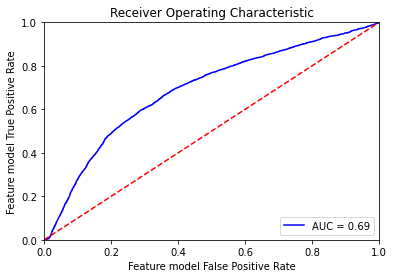

In [23]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Feature model True Positive Rate')
plt.xlabel('Feature model False Positive Rate')
plt.show()

In [25]:
pair_labels2idx

NameError: name 'pair_labels2idx' is not defined

In [27]:
scored_labels = []
for label, idx in pair_label2idx.items():
    prediction = float(model(torch.tensor([idx])))
    scored_labels.append((label, prediction))

In [29]:
sorted(scored_labels, key = lambda x: x[1], reverse=True)

[('S-X', 0.9999891519546509),
 ('X-O', 0.9999864101409912),
 ('X-S', 0.9999771118164062),
 ('S-O', 0.9999169111251831),
 ('O-S', 0.9998831748962402),
 ('O-X', 0.9996850490570068),
 ('S-S', 0.9955033659934998),
 ('X-X', 0.9894610047340393),
 ('O-O', 0.9798129796981812),
 ('_-O', 0.6505981087684631),
 ('_-X', 0.4936102330684662),
 ('X-_', 0.49050530791282654),
 ('O-_', 0.16477036476135254),
 ('_-S', 0.10767403990030289),
 ('S-_', 0.09920826554298401)]